<a href="https://colab.research.google.com/github/jessebuyungo/Proggramming_work/blob/main/Satellite_Image_classification_with_python_Libraries_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Satellite Image classification with python Libraries.**

In [1]:
#install skicit-eo and rasterio

!pip install  rasterio
!pip install scikeo

In [7]:
#Import the required libraris

import rasterio as ras
import rasterio.plot as rplt
import matplotlib.pyplot as plt
import numpy as np
import scikeo as sk
from scikeo.plot import plotRGB
from scikeo.process import extract
from scikeo.mla import MLA
import geopandas as gpd
import matplotlib as mpl
from scikeo.writeRaster import writeRaster

In [4]:
#Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#read the image using  rasterio
image = r'/content/drive/MyDrive/Masters/Ibuje_subcounty.tif'
dataset = ras.open(image)

#Open the metadata of the raster
dataset.meta



{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 1391,
 'height': 1326,
 'count': 5,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'),
 'transform': Affine(30.0, 0.0, 399315.0,
        0.0, -30.0, 226215.0)}

**Plotting an RGB Image of the area**

<Axes: title={'center': 'A True color composite of the study Area'}>

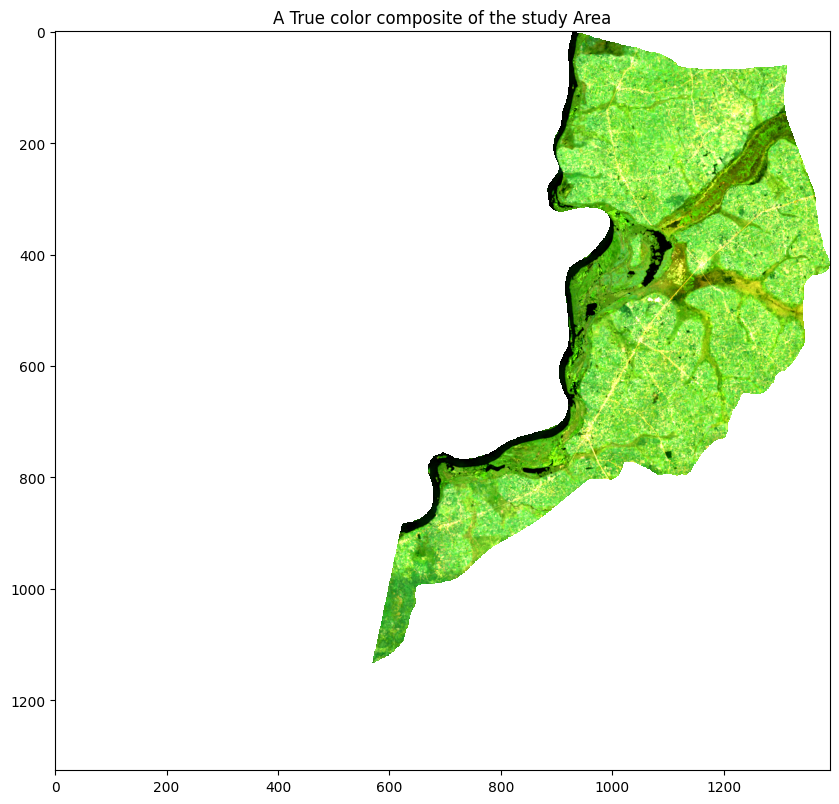

In [9]:
plt.figure(figsize=(10, 10))

plotRGB(
    dataset,
    bands=[2, 3, 4],
    stretch='std',
    title='A True color composite of the study Area',
    xlabel=None,
    ylabel=None,
    ax=None,

)


In [10]:
#read the shapefile containing the training and testing data.

sample_data = r"/content/drive/MyDrive/Masters/sample_datas.shp"

#read shapefile and drop the name column
shp = gpd.read_file(sample_data).drop('name', axis=1)

#create endmenbers
endm = extract(dataset, shp)

#endm = endm.drop('name', axis=1)
endm = extract(dataset, shp)
endm


,class,band1,band2,band3,band4,band5
0,1,0.024290,0.008395,0.016893,0.009632,0.006360
1,1,0.023657,0.007488,0.016425,0.009852,0.005947
2,1,0.031027,0.008313,0.017305,0.010100,0.005975
3,1,0.025610,0.010017,0.018570,0.011942,0.008038
4,1,0.022998,0.016232,0.024152,0.015710,0.010953
...,...,...,...,...,...,...
214,5,0.209585,0.037875,0.058912,0.011722,0.000310
215,5,0.188767,0.036967,0.064412,0.012712,0.001410
216,5,0.185138,0.036005,0.059078,0.010595,-0.000900
217,5,0.190720,0.039772,0.059627,0.012492,0.001162


In [12]:
#let's create a instance of the mla object:
inst = MLA(image = dataset, endmembers = endm)



**Random Forest Classification**

In [18]:
#apply random-forest classification with 80% training data
rf_class = inst.RF(training_split = 0.75)

In [19]:
#Evaluation parameters we can get
rf_class.keys()

dict_keys(['Overall_Accuracy', 'Kappa_Index', 'Confusion_Matrix', 'Classification_Map', 'Image'])

In [20]:
#Evaluation of the classification
print( "Overall_Accuracy: " , rf_class.get('Overall_Accuracy'))

Overall_Accuracy:  0.9818181818181818


In [21]:
 #confusion matrix
 rf_class.get('Confusion_Matrix')

,1,2,3,4,5,Total,Users_Accuracy,Commission
1,7.0,0.0,0.000000,0.0,0.0,7.0,100.000000,0.000000
2,0.0,14.0,0.000000,0.0,0.0,14.0,100.000000,0.000000
3,0.0,0.0,8.000000,0.0,0.0,8.0,100.000000,0.000000
4,0.0,0.0,1.000000,12.0,0.0,13.0,92.307692,7.692308
5,0.0,0.0,0.000000,0.0,13.0,13.0,100.000000,0.000000
Total,7.0,14.0,9.000000,12.0,13.0,NaN,NaN,NaN
Producer_Accuracy,100.0,100.0,88.888889,100.0,100.0,NaN,NaN,NaN
Omission,0.0,0.0,11.111111,0.0,0.0,NaN,NaN,NaN


In [24]:
#Let's define the color palette
# Water(1), Built_up(2), Green_Wetland(3), Other_vegetation(4), Dried-Wetlands(5)
palette = mpl.colors.ListedColormap(['#000080','#FF0000','#00FFFF','#00FF00','#FFFF00'])

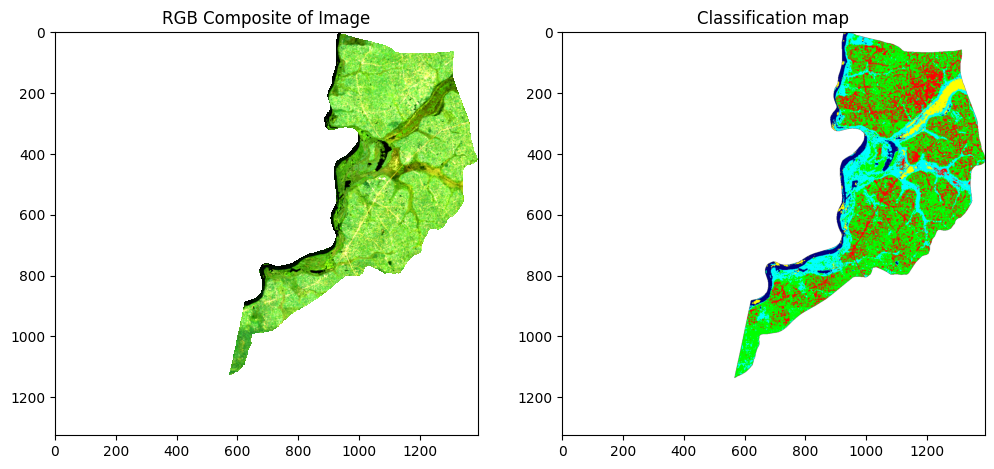

In [25]:
# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 10))

# satellite image
plotRGB(dataset, bands = [2, 3, 4], title = 'RGB Composite of Image', ax = axes[0])

# class results
axes[1].imshow(rf_class.get('Classification_Map'), cmap = palette)
axes[1].set_title("Classification map")
axes[1].grid(False)

In [26]:
#saving the Image
writeRaster(arr = rf_class.get('Classification_Map'), image = dataset, filename = 'rf__classification',
            filepath = '/content/drive/MyDrive/Masters', n = 1)




**Decision Tree Classification**

In [27]:

D_T = inst.DT(training_split=0.8, random_state=None )

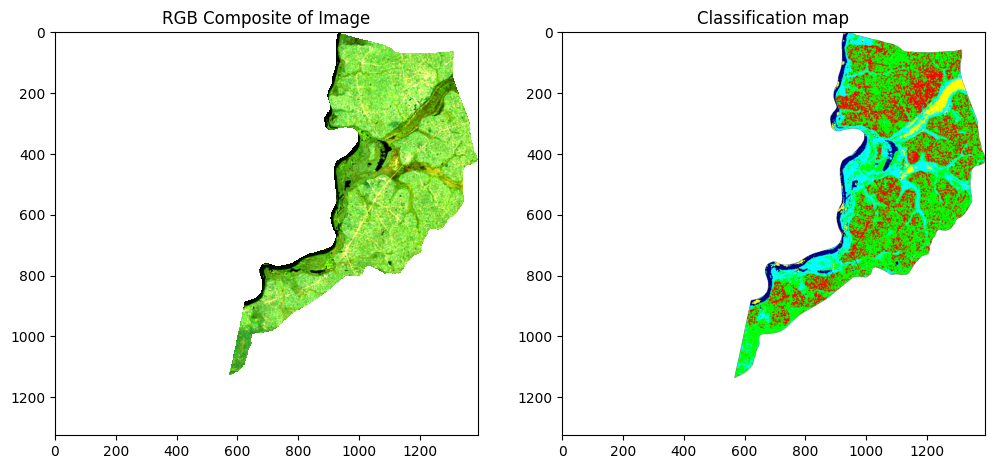

In [28]:
# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 10))

# satellite image
plotRGB(dataset, bands = [2, 3, 4], title = 'RGB Composite of Image', ax = axes[0])

# class results
axes[1].imshow(D_T.get('Classification_Map'), cmap = palette)
axes[1].set_title("Classification map")
axes[1].grid(False)

**Naive Bayes Classification**

In [29]:
naive_bayes_class = inst.NB(training_split=0.8, random_state=None, )

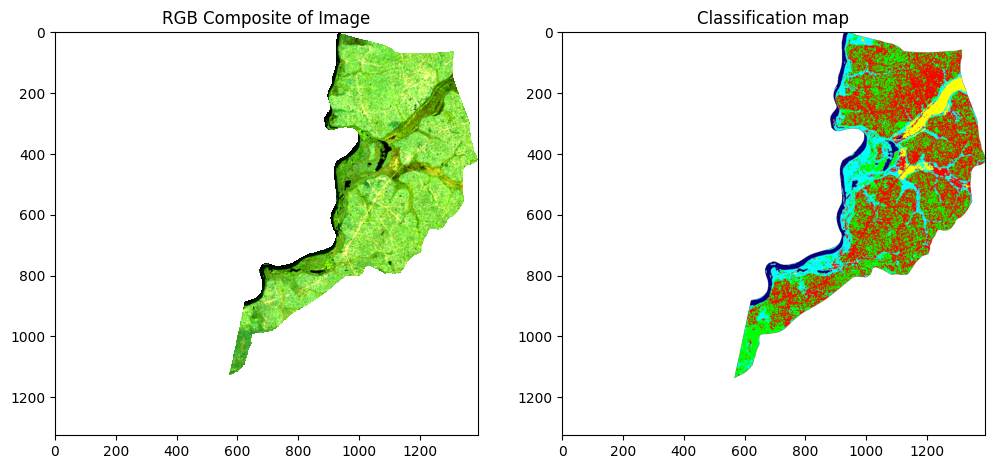

In [30]:
# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 10))

# satellite image
plotRGB(dataset, bands = [2, 3, 4], title = 'RGB Composite of Image', ax = axes[0])

# class results
axes[1].imshow(naive_bayes_class.get('Classification_Map'), cmap = palette)
axes[1].set_title("Classification map")
axes[1].grid(False)